In [1]:
# math etc.
from scipy import misc
import numpy as np

#plotting
import matplotlib as mpl
from matplotlib import pyplot as plt

#image functions, esp. resizing
import cv2
#directory functions
import os

In [2]:
def cuttleVision(cSpher,fN,nStk,off,defAtt):
    img = 1.0*misc.imread(fN)
    sBNarrower = 1.0*misc.imread('./sBandiensisNarrower-1.tif')
    sBNarrow = 1.0*misc.imread('./sBandiensisNarrow-1.tif')
    sBFull = 1.0*misc.imread('./sBandiensisFuller-1.tif')
    
    dimX = np.shape(sBNarrower)[0]
    mid = dimX/2
    dimImg = np.shape(img)[0]
    
    N = 12.5 #25mm eye
    x1, y1 = np.meshgrid(np.arange(-N,N-N/dimX,2*N/dimX),np.arange(-N,N-N/dimX,2*N/dimX))
    
    rad = np.sqrt(x1**2+y1**2)
    
    apDef = np.exp(np.sqrt(3)*(2*rad**2-1))
    apSpher = np.exp(np.sqrt(5) * (6*rad**4 - 6*rad**2+1))
    
    nStk = 2 # three focus depths
    
    
    imgStack = np.zeros([dimImg,dimImg,3])
    
    myPSFDim = 48
    PSF = np.zeros([myPSFDim*2,myPSFDim*2,9])
    
    for c in range(0,nStk+1):
        
        cChromR = 1 - (c / (nStk))
        cChromB = 1.0 - cChromR
        cChromG = 0.5 - cChromR
        if (0):
            apR1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromR/defAtt*apDef+cSpher*apSpher));
            apG1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromG/defAtt*apDef+cSpher*apSpher));
            apB1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromB/defAtt*apDef+cSpher*apSpher));
        if(1):
            apR1 = (sBFull) * np.exp(1j*2*np.pi*(cChromR/defAtt*apDef+cSpher*apSpher));
            apG1 = (sBFull) * np.exp(1j*2*np.pi*(cChromG/defAtt*apDef+cSpher*apSpher));
            apB1 = (sBFull) * np.exp(1j*2*np.pi*(cChromB/defAtt*apDef+cSpher*apSpher));
        
        apR1 = np.nan_to_num(apR1)
        apG1 = np.nan_to_num(apG1)
        apB1 = np.nan_to_num(apB1)
                
        PSF1R = np.abs(np.fft.fft2(apR1))**2
        PSF1G = np.abs(np.fft.fft2(apG1))**2
        PSF1B = np.abs(np.fft.fft2(apB1))**2
        
        #normalize PSFs
        if (0):
            PSF1R = PSF1R/np.max(np.max(PSF1R)); #%abs(fft(apR1)).^2;
            PSF1G = PSF1G/np.max(np.max(PSF1G));
            PSF1B = PSF1B/np.max(np.max(PSF1B));
        
        tempR = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,0],[dimX,dimX])*np.fft.fft2(PSF1R)))
        tempG = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,1],[dimX,dimX])*np.fft.fft2(PSF1G)))
        tempB = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,2],[dimX,dimX])*np.fft.fft2(PSF1B)))
        
        tempR = (tempR - np.min(tempR)) / np.max(tempR)
        tempG = (tempG - np.min(tempG)) / np.max(tempG)
        tempB = (tempB - np.min(tempB)) / np.max(tempB)
        
        tempR = tempR[0:dimImg,0:dimImg]
        tempG = tempG[0:dimImg,0:dimImg]
        tempB = tempB[0:dimImg,0:dimImg]
        
        myPSFDim = 48
        PSF1R = np.fft.fftshift(PSF1R)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1G = np.fft.fftshift(PSF1G)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1B = np.fft.fftshift(PSF1B)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        
        imgStack[:,:,c] = tempR + tempG + tempB
        if(0):
            imgStack[:,:,c*3+0] = tempR
            imgStack[:,:,c*3+1] = tempG
            imgStack[:,:,c*3+2] = tempB
        if(1):
            PSF[:,:,c*3+0] = PSF1R
            PSF[:,:,c*3+1] = PSF1G
            PSF[:,:,c*3+2] = PSF1B
        if (0): #plot for debugging/testing defocus parameters
            plt.figure(figsize=(12,12))
            plt.subplot(321)
            plt.imshow(tempR,cmap='gray')
            plt.subplot(322)
            plt.imshow(tempG,cmap='gray')
            plt.subplot(323)
            plt.imshow(tempB,cmap='gray')
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
            myImgRGB = np.zeros([dimImg,dimImg,3])
            myImgRGB[:,:,0] = tempR
            myImgRGB[:,:,1] = tempG
            myImgRGB[:,:,2] = tempB
            plt.figure(figsize=(6,6))
            plt.imshow(myImgRGB)
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
    return imgStack, PSF

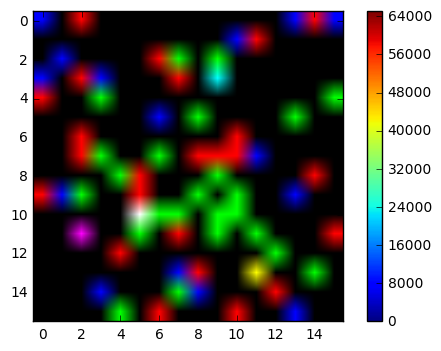

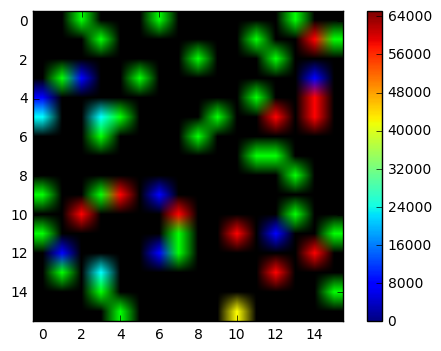

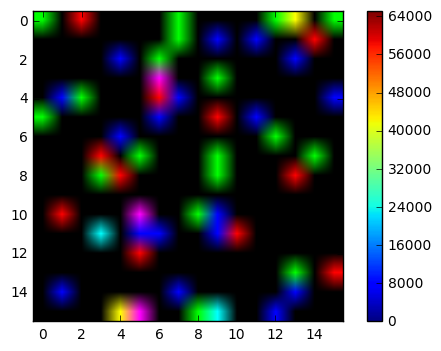

(1024, 16, 16, 3)


In [3]:
#Generate random RGB images

myDimSm = 16
myDimFl = 64
simgStkNo = 1024

#make it deterministic
np.random.seed(1)
simgStk = np.zeros([simgStkNo,myDimSm,myDimSm,3])
for c in range(0,simgStkNo):
    myTestR = 255*( np.random.random([myDimSm,myDimSm]) < 0.07)
    myTestG = 255*( np.random.random([myDimSm,myDimSm]) < 0.125)
    myTestB = 255*( np.random.random([myDimSm,myDimSm]) < 0.07)
    myTest =np.zeros([myDimSm,myDimSm,3])
    myTest[:,:,0] = myTestR
    myTest[:,:,1] = myTestG
    myTest[:,:,2] = myTestB
    myTest = myTest*255
    simgStk[c] = myTest
    if(c % 500 == 0):

        plt.figure()

        plt.imshow(myTest)

        plt.colorbar()
        plt.show()

    
print(np.shape(simgStk))


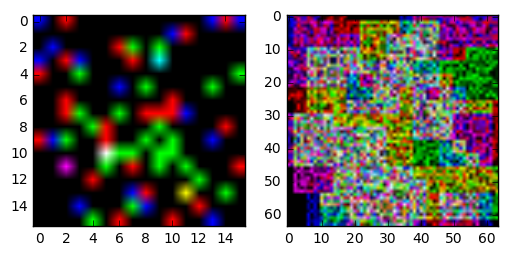

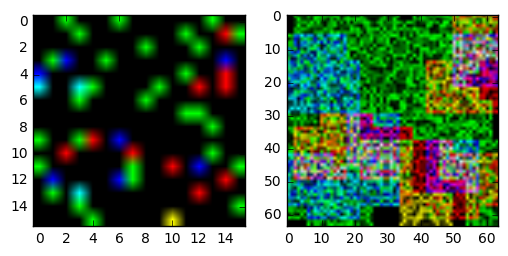

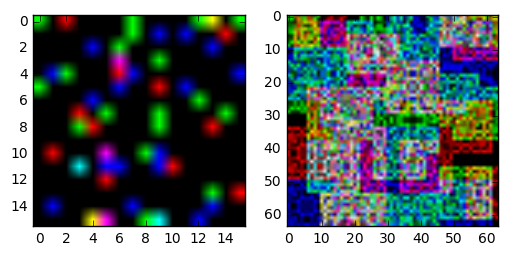

In [4]:
#Resize and store simulated RGB images

simgStkFl = np.zeros([simgStkNo,myDimFl,myDimFl,3])
for c in range(0,simgStkNo):
    myImg = simgStk[c]
    myDimX = np.shape(myImg)[0]
    myDimY = np.shape(myImg)[1]
    if (myDimX < myDimY):
        myDim = myDimX
    else:
        myDim = myDimY
    myImg = myImg[0:myDim,0:myDim,:]
    myResImg = cv2.resize(myImg,(myDimFl,myDimFl), interpolation = cv2.INTER_CUBIC)
    simgStkFl[c] = myResImg
    cv2.imwrite('./sImgs/simulatedImg'+str(c)+'.tif',myResImg)
    if(c % 500 == 0):

        plt.figure()

        plt.subplot(121)
        plt.imshow(simgStk[c])
        plt.subplot(122) 
        plt.imshow(myResImg)
        #plt.colorbar()
        plt.show()

In [ ]:
#shape of the full image stack
print(np.shape(simgStkFl))

simulatedImg901.tif


/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in exp
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in exp
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in multiply


simulatedImg256.tif
simulatedImg648.tif
simulatedImg409.tif
simulatedImg540.tif
simulatedImg387.tif
simulatedImg962.tif
simulatedImg926.tif
simulatedImg622.tif
simulatedImg581.tif
simulatedImg893.tif
simulatedImg279.tif
simulatedImg93.tif
simulatedImg1004.tif
simulatedImg749.tif
simulatedImg908.tif
simulatedImg809.tif
simulatedImg175.tif
simulatedImg635.tif
simulatedImg816.tif
simulatedImg362.tif
simulatedImg415.tif
simulatedImg382.tif
simulatedImg89.tif
simulatedImg861.tif
simulatedImg776.tif
simulatedImg381.tif
simulatedImg110.tif
simulatedImg34.tif
simulatedImg108.tif
simulatedImg173.tif
simulatedImg711.tif
simulatedImg203.tif
simulatedImg224.tif
simulatedImg51.tif
simulatedImg919.tif
simulatedImg396.tif
simulatedImg532.tif
simulatedImg50.tif
simulatedImg290.tif
simulatedImg393.tif
simulatedImg488.tif
simulatedImg761.tif
simulatedImg88.tif
simulatedImg17.tif
simulatedImg820.tif
simulatedImg169.tif
simulatedImg477.tif
simulatedImg895.tif
simulatedImg606.tif
simulatedImg755.tif
simula

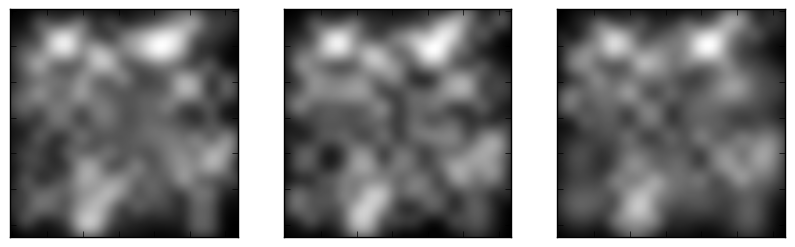

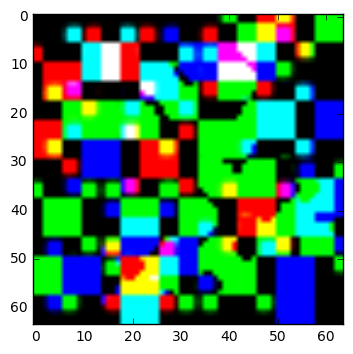

simulatedImg481.tif
simulatedImg82.tif
simulatedImg489.tif
simulatedImg539.tif
simulatedImg986.tif
simulatedImg490.tif
simulatedImg802.tif
simulatedImg557.tif
simulatedImg952.tif
simulatedImg487.tif
simulatedImg684.tif
simulatedImg600.tif
simulatedImg271.tif
simulatedImg243.tif
simulatedImg596.tif
simulatedImg920.tif
simulatedImg314.tif
simulatedImg116.tif
simulatedImg741.tif
simulatedImg390.tif
simulatedImg310.tif
simulatedImg318.tif
simulatedImg61.tif
simulatedImg550.tif
simulatedImg784.tif
simulatedImg36.tif
simulatedImg37.tif
simulatedImg437.tif
simulatedImg879.tif
simulatedImg470.tif
simulatedImg782.tif
simulatedImg725.tif
simulatedImg356.tif
simulatedImg563.tif
simulatedImg681.tif
simulatedImg1017.tif
simulatedImg781.tif
simulatedImg716.tif
simulatedImg703.tif
simulatedImg119.tif
simulatedImg536.tif
simulatedImg869.tif
simulatedImg814.tif
simulatedImg838.tif
simulatedImg249.tif
simulatedImg397.tif
simulatedImg148.tif
simulatedImg837.tif
simulatedImg496.tif
simulatedImg288.tif
sim

In [ ]:
# The full-size simulated RGB image stack is the training target
# now to create an input stack using the cuttleVision function

myMiniDir = os.listdir('./sImgs/')
cSpher = 0
nStk = 3
off = 0
defAtt = 9e3
myTargets = []
myImgs = []

#note cv2 to color function for displaying RGB images
#opencv store images as BGR instead of RGB, so we have to fix it
#cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB)
myC = 0 
for k in myMiniDir:
    myC = myC+1 
    #myImg = cv2.imread('./sImgs/' + str(c))
    print(k)
    #Compute cuttlevision
    imgStk, PSFStk = cuttleVision(cSpher,'./sImgs/'+str(k),nStk,off,defAtt)
    #Load target image
    myImg = cv2.imread('./sImgs/'+str(k))
    myImgs.append(imgStk)
    myTargets.append(myImg)
    
    if (( myC % 250)==0):
        myFig, myAxes = plt.subplots(1,3,figsize=(10,10))
        for c in range(0,4):
            #for x in range(0,3):
            #plt.subplot(3,3,c+1)
            if(c < 3):
                myAxes[c].imshow(imgStk[:,:,c],cmap="gray")
                myAxes[c].set_xticklabels([])
                myAxes[c].set_yticklabels([])
            else:
                plt.figure()
                plt.imshow(cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB))
                #myAxes[c].set_xticklabels([])
                #myAxes[c].set_yticklabels([])
            #plt.tight_layout()
        
    
    plt.show()
    
print("Target vector shape: ", np.shape(myTargets))
print("Training vector shape: ", np.shape(myImgs))
            
        
                                           

In [ ]:
%store myImgs
%store myTargets
print("Targets and training stored")